First, read in the data and check out the columns:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all.count()

koi.1                    7470
rprs                     7202
secthresh                7202
maxrad                   7202
pr_heb                   7048
pr_heb_Px2               7048
pr_eb                    7048
pr_eb_Px2                7048
pr_beb                   7048
pr_beb_Px2               7048
L_tot                    7052
fp                       7052
FPP                      7048
kepid                    7470
period                   7470
rp                       7128
disposition              7470
prob_ontarget            6786
pos_prob_score           7470
not_transitlike          7470
significant_secondary    7470
centroid_offset          7470
ephem_match              7470
MES                      7470
exception                 418
has_ttv                  7268
dtype: int64

Now, we want to split up this whole population into distinct subsets, based on sequential categorizations, in the following order:

* Archive disposition (based on the cumulative table). CONFIRMED and FALSE POSITIVE are their own category; CANDIDATE gets further subdivided.  
* Whether the `vespa` calculation worked or not.
* Whether positional probability calculation is reliable (based on `prob_score_thresh`).  Unreliable goes into "uncertain" category; 
* Reliable positional probs gets further divided based on prob > 0.99 or not.
* Positional prob > 0.99 gets further divided by FPP.  The "newly validated" subset is the subset of these with FPP < 0.01

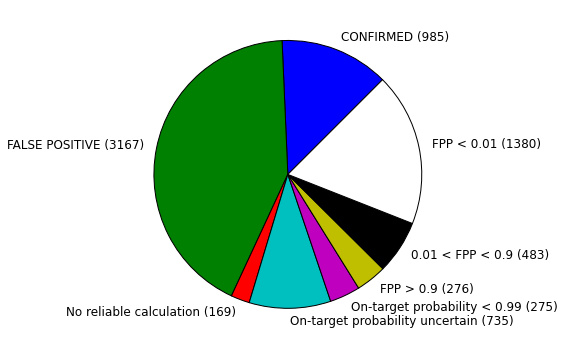

In [2]:
prob_score_thresh = 0.3

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all['FPP'] < 0.01
hi_fpp = fpp_all['FPP'] > 0.9
med_fpp = (fpp_all['FPP'] >= 0.01) & (fpp_all['FPP'] <=0.9)
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['L_tot'] > 1e-3
crazy = fpp_all['L_tot'] <= 1e-3

fpp_calculated = np.isfinite(fpp_all['FPP']) #whether FPP calculation worked

##Just some checks to see if things add up properly
#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp)

categories = [ confirmed, known_fp, 
              (candidate & ~fpp_calculated) | (candidate & fpp_calculated & crazy),
              (candidate & fpp_calculated & not_crazy & target_ambiguous),
              (candidate & fpp_calculated & not_crazy & off_target),
              newfp, newmed, newval]

labels = ['CONFIRMED ({})'.format(categories[0].sum()),
          'FALSE POSITIVE ({})'.format(categories[1].sum()),
          'No reliable calculation ({})'.format(categories[2].sum()),
          'On-target probability uncertain ({})'.format(categories[3].sum()),
          'On-target probability < 0.99 ({})'.format(categories[4].sum()), 
          'FPP > 0.9 ({})'.format(categories[5].sum()), 
          '0.01 < FPP < 0.9 ({})'.format(categories[6].sum()), 
          'FPP < 0.01 ({})'.format(categories[7].sum())]

needmore = categories[2] | categories[3] | categories[4]

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=45);

Let's take a look at just the validated subset, and write that to a file:

In [3]:
fpp_all[newval].count()
fpp_all[newval].to_csv('newly_validated.csv')

In [4]:
fpp_all[newval].head()

,koi.1,rprs,secthresh,maxrad,pr_heb,pr_heb_Px2,pr_eb,pr_eb_Px2,pr_beb,pr_beb_Px2,...,disposition,prob_ontarget,pos_prob_score,not_transitlike,significant_secondary,centroid_offset,ephem_match,MES,exception,has_ttv
koi,,,,,,,,,,,,,,,,,,,,,
K00004.01,K00004.01,0.040,66,0.50,1.050000e-05,3.040000e-05,3.160000e-04,3.090000e-04,4.960000e-04,3.810000e-08,...,CANDIDATE,1,1,False,True,False,False,238.24734,NaN,False
K00049.01,K00049.01,0.026,52,0.50,5.560000e-14,2.940000e-16,8.450000e-17,1.240000e-13,1.910000e-07,1.230000e-06,...,CANDIDATE,1,1,False,False,False,False,93.30270,NaN,False
K00089.01,K00089.01,0.017,34,0.75,3.870000e-18,1.190000e-21,1.690000e-22,1.820000e-27,2.160000e-14,4.090000e-39,...,CANDIDATE,1,1,False,False,False,False,71.36428,NaN,True
K00092.01,K00092.01,0.024,49,0.57,1.190000e-05,1.600000e-10,6.520000e-04,2.230000e-06,4.190000e-07,1.120000e-10,...,CANDIDATE,1,1,False,False,False,False,76.26120,NaN,False
K00105.01,K00105.01,0.031,27,0.50,3.420000e-06,5.250000e-09,2.660000e-08,2.570000e-07,2.080000e-05,6.740000e-09,...,CANDIDATE,1,1,False,False,False,False,197.65842,NaN,False


In [11]:
from keputils import koiutils as ku

In [15]:
import re
for c in ku.DATA.columns:
    print c

kepid
kepoi_name
kepler_name
ra
ra_err
ra_str
dec
dec_err
dec_str
koi_gmag
koi_gmag_err
koi_rmag
koi_rmag_err
koi_imag
koi_imag_err
koi_zmag
koi_zmag_err
koi_jmag
koi_jmag_err
koi_hmag
koi_hmag_err
koi_kmag
koi_kmag_err
koi_kepmag
koi_kepmag_err
koi_delivname
koi_vet_stat
koi_quarters
koi_disposition
koi_pdisposition
koi_count
koi_num_transits
koi_max_sngle_ev
koi_max_mult_ev
koi_bin_oedp_sig
koi_limbdark_mod
koi_ldm_coeff4
koi_ldm_coeff3
koi_ldm_coeff2
koi_ldm_coeff1
koi_trans_mod
koi_model_snr
koi_model_dof
koi_model_chisq
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_eccen
koi_eccen_err1
koi_eccen_err2
koi_longp
koi_longp_err1
koi_longp_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_period
koi_period_err1
koi_period_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_dor
koi_dor_e